In [1]:
#Imports some of the libraries that we will be using
import pandas as pd
import numpy as np
import math
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')

In [2]:
from load_dataset import load
from classifier import NeuralNetwork, Logistic_Regression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from expl import explanation_candidate_generation, get_top_k_expl
from influence import *

['acs_income.csv', 'acs_influence 1.ipynb', 'acs_influence all solutions.ipynb', 'acs_influence_new.ipynb', 'adult.data', 'adult.test', 'adult_influence 1.ipynb', 'adult_influence copy.ipynb', 'classifier.py', 'compas-scores-two-years.csv', 'compas_influence 1.ipynb', 'compas_influence.ipynb', 'config.json', 'entropy_test.ipynb', 'expl.py', 'functions.py', 'german.data', 'german_influence 1 copy.ipynb', 'german_influence 1.ipynb', 'german_influence.ipynb', 'influence.py', 'influence_functions.ipynb', 'load_dataset.py', 'loss.py', 'metrics.py', 'meu_test.ipynb', 'random_influence.ipynb', 'sqf_influence 1.ipynb', 'sqf_influence.ipynb', 'sqf_test.csv', 'sqf_train.csv', 'utils.py', '__pycache__']


In [3]:
#Function to run the logistic regression model based on classifier.py
def lr_model(training_df, test_attr_df, classifier):
    changed_df_labels = training_df.pop('is_recid')
    changed_df_attr = training_df.to_numpy()

    classifier.fit(changed_df_attr,changed_df_labels.values)
    y_predicted = classifier.predict_proba(test_attr_df)

    training_df['is_recid'] = changed_df_labels

    return y_predicted


<h4>Removal Based Influence Calculation<h4>

In [4]:
dataset = 'compas'
clf_name = 'Logistic_Regression'
metric = 0
support = 0.05
support_small = 0.3

In [5]:
X_train, X_test, y_train, y_test = load(dataset)

In [6]:
duplicates = 1
make_duplicates = lambda x, d: pd.concat([x]*d, axis=0).reset_index(drop=True)
X_train = make_duplicates(X_train, duplicates)
X_test = make_duplicates(X_test, duplicates)
y_train = make_duplicates(y_train, duplicates)
y_test = make_duplicates(y_test, duplicates)

In [7]:
import copy
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
predictors = ['event', 'priors_count', 'juv_other_count', 'juv_misd_count',
       'juv_fel_count', 'race', 'age_cat', 'sex', 'score_text']
target_var =['is_recid']

In [ ]:
#Combine x_train and y_train
#I combine these so that when I flip the labels I have one DF that I work with
#Rather than 2 numpy.ndarrays
train_demo_df = pd.DataFrame(X_train, columns = predictors)
train_outcome_df = y_train.to_frame()
#train_outcome_df=train_outcome_df.rename(columns={'credit':'credit_risk'})
train_full_df = pd.concat([train_demo_df, train_outcome_df], axis=1)

In [10]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, Logistic_Regression):
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch
elif isinstance(clf, NeuralNetwork):
    loss_func = nn_loss_torch
else:
    raise NotImplementedError

In [11]:
clf = eval(clf_name)(input_size=X_train.shape[-1])

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.10664561084432223
Initial TPR parity:  0.04579037130140762
Initial predictive parity:  0.057398965624464116
Initial accuracy:  0.9085239085239085


<h3>Entropy<h3>

In [12]:
entropy_start = time.time()
#Remake the dataset
entropy_train_df = train_full_df.copy()

In [13]:
#Calculate the probability of each datapoint using the same one of as the lrmodel function
orig_entropy_prob = clf.predict_proba(X_train)
flipped_entropy_prob = 1-orig_entropy_prob

In [14]:
#Log base two would be: log = math.log(x,2)
#Entropy equation would then be: -1*(p1((math.log(p1,2))+p2*(math.log(p2,2)))

#In the predicted_probabilities: first value is 0 (which is bad), second value is 1 (which is good)

#Loop through the predicted_probabilities array and calculate values
#One list will contain the index of each row in the table and the other will contain the entropy value of each row

index_list = []
entropy_list = []

for index in range(len(X_train)):
  #Calculate p1 and p2
  p1=orig_entropy_prob[index]
  p2=flipped_entropy_prob[index]
  #print(f"Index: {index}, p1: {p1}, p2: {p2}")
  #Calculate entropy in 3 steps
  entropy_calc1 = p1 * math.log(p1,2) if p1 > 0 else 0
  entropy_calc2 = p2 * math.log(p2,2) if p2 > 0 else 0
  entropy_final = -1 * (entropy_calc1 + entropy_calc2)

  #Append the values to their respective lists
  index_list.append(index)
  entropy_list.append(entropy_final)

In [15]:
#Rank the entropy values in decreasing order
#Match the index list with them

#Combine the two lists using zip
combined_list = list(zip(entropy_list, index_list))

#Sort the combined lust based on entropy values in descending order
sorted_list = sorted(combined_list, key = lambda x: x[0], reverse=True)

#Extract the values
sorted_ent_list, sorted_index_list = zip(*sorted_list)
entropy_end = time.time() - entropy_start

In [16]:
entropy_train_df['is_recid'] = entropy_train_df['is_recid'].astype('int')

In [17]:
ranked_ent_list = list(sorted_ent_list)
ranked_idx_list = list(sorted_index_list)

In [18]:
#After the ranking; flip based on the ranked entropy values
#Values with the highest entropy are prioritized for flipping

# ranked_ent_parity_list = [spd_0]
ranked_ent_parity_list = []
ranked_flip = []

row_num = 0

#Loop through and flip based on the entropy values
for row in range(len(sorted_index_list)):
    row_num = ranked_idx_list[row]
    if entropy_train_df.at[row_num,'is_recid'] == 0:
        entropy_train_df.at[row_num,'is_recid'] = 1
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

    elif entropy_train_df.at[row_num,'is_recid'] == 1:
        entropy_train_df.at[row_num,'is_recid'] = 0
        ranked_ent_pred = lr_model(entropy_train_df, X_test, clf)
        ranked_ent_parity = computeFairness(ranked_ent_pred, X_test_orig, y_test, 0, dataset)
        ranked_ent_parity_list.append(ranked_ent_parity)

In [19]:
#entropy_time = entropy_end - entropy_start
#sol_time.append(entropy_end)

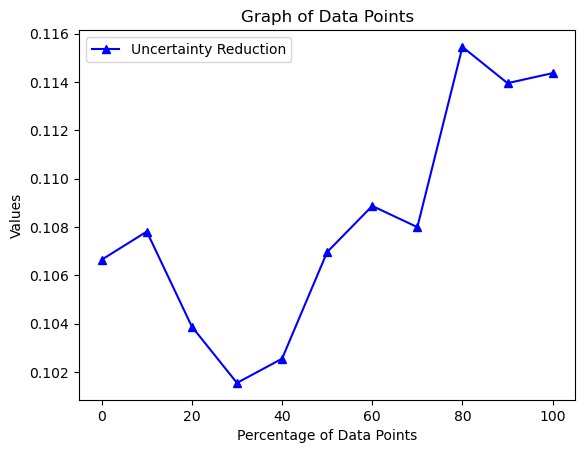

In [20]:
datapoints_ent = len(ranked_ent_parity_list)

#indices at 10 points along the graph
indices = [int(i * datapoints_ent / 10) for i in range(0, 10)]

# # Extract the values at these indices
# values_entropy = [ranked_ent_parity_list[index] for index in indices]

values_entropy = []
values_entropy.append(spd_0)
for index in range(1, len(indices) + 1):
    values_entropy.append(ranked_ent_parity_list[index * 80 - 1])

#Plot the Values
plt.plot([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], values_entropy, label='Uncertainty Reduction', color='Blue', marker = '^')

# Add labels and legend
plt.xlabel('Percentage of Data Points')
plt.ylabel('Values')
plt.title('Graph of Data Points')
plt.legend()

# Show the plot
plt.show()